In [1]:
import sys
import subprocess
import json
import os
import matplotlib.pyplot as plt
from functools import reduce


sys.path.append(os.path.abspath("../generation"))
import generate
from parseRePEAT import *

In [2]:
def plot_atf(segments, label, color, eatfs):
    line = None
    for (x0, x1, y0, y1) in segments:
        if x0 == "-inf" and x1 != "inf" and y1 != "inf":
            plt.hlines(float(y1), 0, float(x1), colors=color)
        line, = plt.plot([float(x0), float(x1)], [float(y0), float(y1)], color=color)
    line.set_label(label) if line is not None else None

    for (zeta, alpha, beta, delta, gammas) in list(eatfs.values())[0]:
        gamma = reduce(lambda x, y: float(x) + float(y), gammas)
        plt.plot([float(alpha), float(beta)], [float(gamma), float(gamma)], color=color)

def generate_intervals(max_delay, layout, scenario, agent, agent_speed, move, color="red"):
    # Generate intervals
    # generate.time_safe_intervals_and_write(layout, scenario, agent["trainNumber"], agent_speed, "output", max_delay)
    generate.time_safe_intervals_and_write(layout, scenario, -1, 20, "output", max_delay)
    # start = "r-n3_2" if agent["trainNumber"] == 1 else "t-n3_1"
    start = "r-n3_2"
    timeout = 60
    try:
        # proc = subprocess.run(["atsipp.exe", "--start", start, "--goal", "r-14", "--edgegraph", "output", "--search", "repeat", "--startTime", str(move["startTime"])], timeout=20, stdout=subprocess.PIPE, stderr=subprocess.DEVNULL)
        proc = subprocess.run(["Y:/Uni/Thesis/executable/atsipp.exe", "--start", "r-n3_2", "--goal", "r-14", "--edgegraph", "output", "--search", "repeat", "--startTime", "0"], timeout=timeout, stdout=subprocess.PIPE, stderr=subprocess.DEVNULL)

    except subprocess.TimeoutExpired:
        print(f'Timeout for repeat ({timeout}s) expired')
        return
    repeat_output = str(proc.stdout).split("'")[1].rsplit("\\r\\n")

    # If the run was successful
    if int(proc.returncode) == 0:
        metadata, catf, paths, eatfs = parse_list_of_outputs(repeat_output)
        print(f"eats: {eatfs}")
        print(f"cats: {catf}")
        label = f"{max_delay}s buffer time" if max_delay > 0 else "No flexibility"
        plot_atf(catf, label, color, eatfs)

eats: {'r-n3_2;r-n2_2;r-2;r-3;r-4;r-5;r-6;r-7;r-8;r-9;r-10;r-11;r-12;r-13;r-14': [('-inf', '0', '35', '675', ['0', '173']), ('-inf', '35', '133', '675', ['0', '163']), ('-inf', '133', '163', '675', ['0', '366']), ('-inf', '163', '198', '675', ['0', '336']), ('-inf', '198', '825', '675', ['0', '0'])]}
cats: [('-inf', '0', '675', '675'), ('0', '35', '675', '710'), ('35', '133', '710', '808'), ('133', '163', '808', '838'), ('163', '198', '838', '873'), ('198', '825', '873', '1500'), ('825', 'inf', 'inf', 'inf')]
eats: {'r-n3_2;r-n2_2;r-2;r-3;r-4;r-5;r-6;r-7;r-8;r-9;r-10;r-11;r-12;r-13;r-14': [('-inf', '198', '825', '675', ['0', '0'])]}
cats: [('-inf', '198', '873', '873'), ('198', '825', '873', '1500'), ('825', 'inf', 'inf', 'inf')]


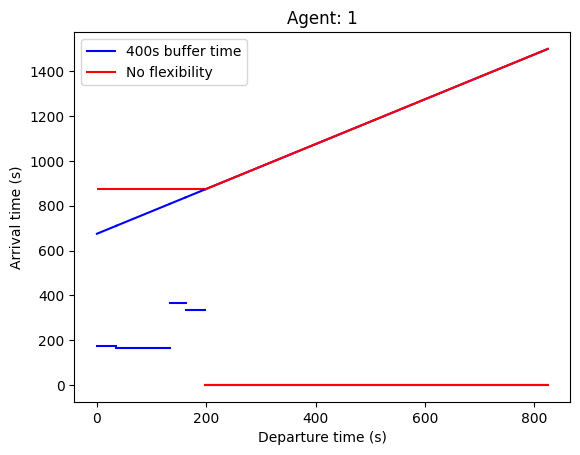

In [3]:
# Run RePeAT to get multiple plans
scenario = "../data/single_track/scenario_following.json"
layout =   "../data/single_track/woho.json"

scenario_data = json.load(open(scenario))
train_types = {x["name"]: x for x in scenario_data["types"]}
for agent in scenario_data['trains']:
    # Get the global end time of scenario
    scenario_end_time = 0
    for i in range(len(agent["movements"])):
        move = agent["movements"][i]
        if 2 * move["endTime"] > scenario_end_time:
            scenario_end_time = 2 * move["endTime"]
    agent_speed = train_types[agent["trainUnitTypes"][0]]["speed"] * 1.09
    # agent_speed = 60
    for move in agent["movements"]:
        # Difference
        # generate_intervals(700, layout, scenario, agent, agent_speed, move, color="green")
        generate_intervals(400, layout, scenario, agent, agent_speed, move, color="blue")

        # baseline
        generate_intervals(0,   layout, scenario, agent, agent_speed, move)

        title = f"Agent: {agent['trainNumber']}"
        plt.xlabel("Departure time (s)")
        plt.ylabel("Arrival time (s)")
        plt.title(title)
        plt.legend()
        plt.show()

